In [1]:
import os
import sys
from pathlib import Path
import pytorch_lightning as pl
import torch
from pathlib import Path
from sklearn.datasets import make_blobs
from itertools import cycle
from typing import List, Optional, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import cm, patches
from scipy.stats import multivariate_normal
from sklearn.datasets import make_blobs

In [2]:
sys.path.append(str(Path(os.getcwd()).resolve().parent))
from src.gmm import GaussianMixtureModel, GMMDataModule, get_gmm_trainer

In [3]:
SEED = 13
np.random.seed(SEED)
torch.manual_seed(SEED)


In [4]:
# funkcja z laboratorium pgm
CMAP = plt.cm.get_cmap("Dark2", 8)
def visualize(
    points: Optional[np.ndarray] = None,
    gaussians: Optional[List[Tuple[np.ndarray, np.ndarray, float]]] = None,
    fig: Optional[plt.Figure] = None,
    lims: int = 2,
) -> Tuple[plt.Figure, Tuple[plt.Axes, ...]]:
    """Wizualizacja mikstury rozkładów normalnych.
    
    :param points: punkty 2D do wizualizacji
    :param gaussians: lista krotek zawierających
        macierz średnich, macierz kowariancji i mixing coefficients
    :param fig: figure do rysowania
    """
    handles = []
    labels = []
    if fig is None:
        fig = plt.figure(figsize=(14, 5))
        ax1 = fig.add_subplot(131)
        ax2 = fig.add_subplot(132)
        ax3 = fig.add_subplot(133, projection="3d")
    else:
        ax1, ax2, ax3 = fig.get_axes()
        ax1.clear()
        ax2.clear()
        ax3.clear()
    
    ax1.set_xlim(-lims, lims)
    ax1.set_ylim(-lims, lims)
    ax2.set_xlim(-lims, lims)
    ax2.set_ylim(-lims, lims)
    ax3.set_xlim(-lims, lims)
    ax3.set_ylim(-lims, lims)
    ax3.set_zlim(0, 0.5)
        
    if points is not None:
        ax1.scatter(
            points[:, 0], 
            points[:, 1],
            s=4,
            c="black",
            alpha=0.3, 
            marker="x",
            label="punkty"
        )
        h, l = ax1.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    
    if gaussians is not None:
        cmap = cycle(CMAP(i) for i in range(len(gaussians)))
        x = np.linspace(-lims, lims, 201)
        y = np.linspace(-lims, lims, 201)
        xs, ys = np.meshgrid(x, y)
        positions = np.stack((xs, ys), axis=2)
        zs = np.zeros_like(xs)

        for idx, (mu, sigma, pi) in enumerate(gaussians):
            c = next(cmap)
            label = f"komponent {idx}"
            rv = multivariate_normal(mu, sigma)
            zk = rv.pdf(positions)
            zs += pi * zk
            contour = ax1.contour(xs, ys, zk, levels=3, colors=[c])
            handles.append(patches.Patch(color=c, label=label))
            labels.append(label)

        ax2.contour(xs, ys, zs, levels=5)

        ax3.plot_surface(xs, ys, zs, cmap=cm.coolwarm)
        
    fig.legend(handles, labels, loc='center left')
    return fig, (ax1, ax2, ax3)

/tmp/ipykernel_1294/2711152252.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  CMAP = plt.cm.get_cmap("Dark2", 8)


In [5]:
blob, _ = make_blobs(
    500,
    random_state=0, 
    centers=((-3, -2), (4, 3), (2.5, -1.8)), 
    cluster_std=(0.7, 1.2, 0.9)
)
blob = (blob - blob.mean(axis=0)) / blob.std(axis=0)

toy_data = torch.from_numpy(blob).float()
datamodule = GMMDataModule(toy_data)

In [6]:
trainer = get_gmm_trainer('test_gmm', 50, patience=1)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [7]:
model = GaussianMixtureModel(3, 2, smoothing=None)

trainer.fit(model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/witcher/jakub/ure/representation_clustering/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 21     | n/a 
---------------------------------------------
0         Trainable params
21        Non-trainable params
21        Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/witcher/jakub/ure/representation_clustering/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s, v_num=0]

/home/witcher/jakub/ure/representation_clustering/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/optimization/automatic.py:134: `training_step` returned `None`. If this was on purpose, ignore this warning...
Metric log-likelihood improved. New best score: -2.627


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 56.21it/s, v_num=0]

Metric log-likelihood improved by 0.024 >= min_delta = 0.001. New best score: -2.603


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 42.09it/s, v_num=0]

Metric log-likelihood improved by 0.016 >= min_delta = 0.001. New best score: -2.587


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 37.69it/s, v_num=0]

Metric log-likelihood improved by 0.030 >= min_delta = 0.001. New best score: -2.557


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 74.44it/s, v_num=0]

Metric log-likelihood improved by 0.064 >= min_delta = 0.001. New best score: -2.493


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 67.32it/s, v_num=0]

Metric log-likelihood improved by 0.114 >= min_delta = 0.001. New best score: -2.378


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  7.87it/s, v_num=0]

Metric log-likelihood improved by 0.070 >= min_delta = 0.001. New best score: -2.308


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 64.65it/s, v_num=0]

Metric log-likelihood improved by 0.019 >= min_delta = 0.001. New best score: -2.290


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 83.42it/s, v_num=0] 

Metric log-likelihood improved by 0.012 >= min_delta = 0.001. New best score: -2.277


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 79.49it/s, v_num=0] 

Metric log-likelihood improved by 0.011 >= min_delta = 0.001. New best score: -2.266


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 79.14it/s, v_num=0] 

Metric log-likelihood improved by 0.010 >= min_delta = 0.001. New best score: -2.257


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 92.30it/s, v_num=0] 

Metric log-likelihood improved by 0.007 >= min_delta = 0.001. New best score: -2.250


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 107.48it/s, v_num=0]

Metric log-likelihood improved by 0.004 >= min_delta = 0.001. New best score: -2.246


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 84.06it/s, v_num=0] 

Metric log-likelihood improved by 0.002 >= min_delta = 0.001. New best score: -2.244


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 72.22it/s, v_num=0]

Metric log-likelihood improved by 0.002 >= min_delta = 0.001. New best score: -2.242


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 75.41it/s, v_num=0]

Metric log-likelihood improved by 0.001 >= min_delta = 0.001. New best score: -2.241


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 48.92it/s, v_num=0]

Metric log-likelihood improved by 0.001 >= min_delta = 0.001. New best score: -2.239


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 61.13it/s, v_num=0]

Metric log-likelihood improved by 0.002 >= min_delta = 0.001. New best score: -2.238


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 57.90it/s, v_num=0] 

Metric log-likelihood improved by 0.002 >= min_delta = 0.001. New best score: -2.236


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 93.46it/s, v_num=0] 

Metric log-likelihood improved by 0.002 >= min_delta = 0.001. New best score: -2.233


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 80.19it/s, v_num=0] 

Metric log-likelihood improved by 0.004 >= min_delta = 0.001. New best score: -2.230


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 85.64it/s, v_num=0] 

Metric log-likelihood improved by 0.006 >= min_delta = 0.001. New best score: -2.223


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 84.75it/s, v_num=0] 

Metric log-likelihood improved by 0.012 >= min_delta = 0.001. New best score: -2.211


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 87.19it/s, v_num=0] 

Metric log-likelihood improved by 0.028 >= min_delta = 0.001. New best score: -2.184


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 98.79it/s, v_num=0] 

Metric log-likelihood improved by 0.077 >= min_delta = 0.001. New best score: -2.107


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 92.04it/s, v_num=0] 

Metric log-likelihood improved by 0.187 >= min_delta = 0.001. New best score: -1.919


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 91.17it/s, v_num=0] 

Metric log-likelihood improved by 0.189 >= min_delta = 0.001. New best score: -1.730


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 99.43it/s, v_num=0] 

Metric log-likelihood improved by 0.054 >= min_delta = 0.001. New best score: -1.676


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 93.75it/s, v_num=0] 

Monitored metric log-likelihood did not improve in the last 1 records. Best score: -1.676. Signaling Trainer to stop.


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 58.15it/s, v_num=0]


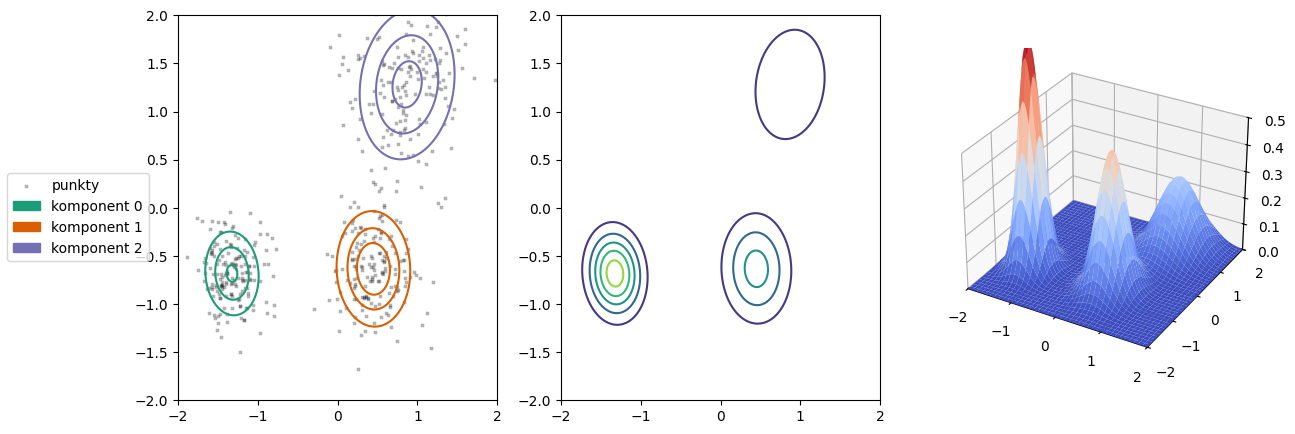

In [8]:
visualize(
    points=toy_data.numpy(),
    gaussians=[
        (mu, sigma, pi)
        for mu, sigma, pi 
        in zip(
            model.means.data.numpy(),
            model.covariances.data.numpy(),
            model.mixing_coefs.data.numpy(),
        )
    ],
)
plt.show()

In [9]:
trainer = get_gmm_trainer('test_gmm', 50, patience=1)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [10]:
model = GaussianMixtureModel(3, 2)

trainer.fit(model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 21     | n/a 
---------------------------------------------
0         Trainable params
21        Non-trainable params
21        Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 72.95it/s, v_num=1]

Metric log-likelihood improved. New best score: -2.548


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 67.47it/s, v_num=1]

Metric log-likelihood improved by 0.148 >= min_delta = 0.001. New best score: -2.400


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 90.91it/s, v_num=1] 

Metric log-likelihood improved by 0.173 >= min_delta = 0.001. New best score: -2.227


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 85.14it/s, v_num=1] 

Metric log-likelihood improved by 0.092 >= min_delta = 0.001. New best score: -2.135


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 71.48it/s, v_num=1]

Metric log-likelihood improved by 0.026 >= min_delta = 0.001. New best score: -2.109


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 67.18it/s, v_num=1]

Metric log-likelihood improved by 0.014 >= min_delta = 0.001. New best score: -2.095


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 69.64it/s, v_num=1]

Metric log-likelihood improved by 0.009 >= min_delta = 0.001. New best score: -2.086


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 79.33it/s, v_num=1] 

Metric log-likelihood improved by 0.004 >= min_delta = 0.001. New best score: -2.082


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 59.99it/s, v_num=1]

Metric log-likelihood improved by 0.003 >= min_delta = 0.001. New best score: -2.079


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 44.57it/s, v_num=1]

Metric log-likelihood improved by 0.003 >= min_delta = 0.001. New best score: -2.076


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 55.33it/s, v_num=1]

Metric log-likelihood improved by 0.003 >= min_delta = 0.001. New best score: -2.073


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 45.29it/s, v_num=1]

Metric log-likelihood improved by 0.005 >= min_delta = 0.001. New best score: -2.068


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 35.67it/s, v_num=1]

Metric log-likelihood improved by 0.008 >= min_delta = 0.001. New best score: -2.060


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 75.65it/s, v_num=1] 

Metric log-likelihood improved by 0.014 >= min_delta = 0.001. New best score: -2.047


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 42.43it/s, v_num=1]

Metric log-likelihood improved by 0.017 >= min_delta = 0.001. New best score: -2.029


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 78.30it/s, v_num=1]

Metric log-likelihood improved by 0.014 >= min_delta = 0.001. New best score: -2.015


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 65.24it/s, v_num=1]

Metric log-likelihood improved by 0.009 >= min_delta = 0.001. New best score: -2.006


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 77.17it/s, v_num=1] 

Metric log-likelihood improved by 0.007 >= min_delta = 0.001. New best score: -2.000


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 68.19it/s, v_num=1]

Metric log-likelihood improved by 0.007 >= min_delta = 0.001. New best score: -1.993


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 62.55it/s, v_num=1]

Metric log-likelihood improved by 0.011 >= min_delta = 0.001. New best score: -1.982


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 68.36it/s, v_num=1]

Metric log-likelihood improved by 0.020 >= min_delta = 0.001. New best score: -1.961


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 52.45it/s, v_num=1]

Metric log-likelihood improved by 0.042 >= min_delta = 0.001. New best score: -1.919


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 81.50it/s, v_num=1]

Metric log-likelihood improved by 0.083 >= min_delta = 0.001. New best score: -1.836


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 104.43it/s, v_num=1]

Metric log-likelihood improved by 0.091 >= min_delta = 0.001. New best score: -1.745


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 79.16it/s, v_num=1] 

Metric log-likelihood improved by 0.022 >= min_delta = 0.001. New best score: -1.724


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 81.45it/s, v_num=1]

Metric log-likelihood improved by 0.014 >= min_delta = 0.001. New best score: -1.710


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 81.38it/s, v_num=1]

Metric log-likelihood improved by 0.013 >= min_delta = 0.001. New best score: -1.697


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 78.65it/s, v_num=1] 

Metric log-likelihood improved by 0.010 >= min_delta = 0.001. New best score: -1.687


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 84.98it/s, v_num=1] 

Metric log-likelihood improved by 0.006 >= min_delta = 0.001. New best score: -1.681


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 70.67it/s, v_num=1]

Metric log-likelihood improved by 0.003 >= min_delta = 0.001. New best score: -1.679


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 90.27it/s, v_num=1] 

Metric log-likelihood improved by 0.002 >= min_delta = 0.001. New best score: -1.677


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 105.51it/s, v_num=1]

Monitored metric log-likelihood did not improve in the last 1 records. Best score: -1.677. Signaling Trainer to stop.


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 58.97it/s, v_num=1] 


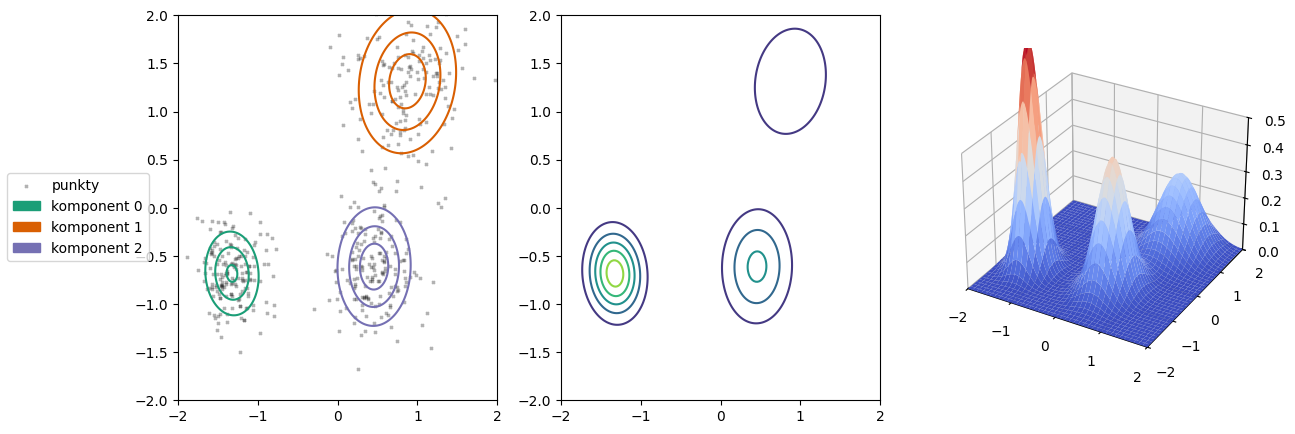

In [11]:
visualize(
    points=toy_data.numpy(),
    gaussians=[
        (mu, sigma, pi)
        for mu, sigma, pi 
        in zip(
            model.means.data.numpy(),
            model.covariances.data.numpy(),
            model.mixing_coefs.data.numpy(),
        )
    ],
)
plt.show()

In [12]:
%load_ext tensorboard
%tensorboard --logdir ../data/gmm-logs/ --port 6006

Launching TensorBoard...